## Motivation

Sequence-to-sequence (Seq-to-Seq) models are a common solution for tasks with a natural sequential structure, such as translating sentences into another language [@sutskever-2014]. These models are particularly useful because they can handle variable-length inputs and outputs. But what happens when the underlying task has no order?

Sorting a set of numbers is a good example, which we explore in this article. Here, a Seq-to-Seq model would not work optimally because the order of the numbers in the input data could affect the result [@vinyals-2015A]. This highlights the limitations of Seq-to-Seq when it comes to processing sets rather than sequences.

In the following sections, we will explore how to develop an architecture that can handle such Set-to-Set tasks. The implementations presented are based on theory from several scientific papers, including concepts such as attention [@graves-2014], pointer networks [@vinyals-2015B], and the Read-Process-Write architecture [@vinyals-2015A].

## Setup

::: {.callout-note}
In order to understand the following content, we assume basic knowledge of neural networks, backpropagation and Seq-to-Seq models. We will rely on the PyTorch library for the implementation. We have provided further literature for each approach. This can be used both to deepen your knowledge and to go deeper into a topic if you are having difficulty understanding it.
:::


### Dataset

As a benchmark for the models in this experiment, we will conduct a number-sorting experiment similar to @vinyals-2015A on arrays with a length $s$ (controlled by a hyperparameter) containing numbers normalized to $[-1;1]$. The network will receive an unordered array $x$ and has to learn to output an ordered array $y$.

In [1]:
#| echo: false
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import ast

In [2]:
#| code-fold: true
#| code-summary: Hyperparameters
# Dataset
SEQ_LENGTH = 5
NUM_SAMPLES = 2000

# Model
ITEM_SIZE = 1
EMBEDDING_SIZE = 32
HIDDEN_SIZE = 32
BATCH_SIZE = 256
PROCESS_STEPS = 5 # RPW model

# Training
LR = 0.01
N_EPOCHS = 250

In [3]:
class DigitSortDataset(Dataset):
    def __init__(self, num_samples, seq_length):
        self.num_samples = num_samples
        self.seq_length = seq_length
        self.data = self.generate_data()

    def generate_data(self):
        data = []
        for _ in range(self.num_samples):
            sequence = [random.random() for _ in range(self.seq_length)]
            unsorted = torch.tensor(sequence, dtype=torch.float32)
            sorted_seq = torch.sort(unsorted)[0]
            data.append((unsorted, sorted_seq))
        return data

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return self.data[idx]

In [4]:
#| code-fold: true
#| code-summary: Dataloader creation
# Create the datasets
train_val_dataset = DigitSortDataset(num_samples=NUM_SAMPLES, seq_length=SEQ_LENGTH)

# Split the train_val_dataset
train_size = int(0.8 * len(train_val_dataset))
val_size = len(train_val_dataset) - train_size

train_dataset, val_dataset = random_split(
    train_val_dataset, [train_size, val_size]
)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

For the rest of this article, we will be using arrays with $s=5$, but the reader can adjust this value in the Jupyter Notebook. An example for a training pair $(x,y)$ from the data loader looks as follows:

In [5]:
#| echo: false
example_x, example_y = train_dataset[0]
print("Example x:", example_x)
print("Example y:", example_y)

Example x: tensor([0.8946, 0.3203, 0.5510, 0.4022, 0.6636])
Example y: tensor([0.3203, 0.4022, 0.5510, 0.6636, 0.8946])


### Training functions

As a final step for the setup, we will define a few functions which will be used to train and evaluate the models in the next few sections. You can ignore these functions for now, but if you're interested in how they work, you can unfold the code-blok below.

In [6]:
#| code-fold: true
#| code-summary: Training, 
def train(model, dataloader, use_cross_entropy):
    criterion = nn.CrossEntropyLoss() if use_cross_entropy else nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=LR)

    model.train()
    total_loss = 0
    for epoch in range(N_EPOCHS):
        total_loss = 0
        for batch in dataloader:
            unsorted, sorted_seq = batch

            prediction = model(unsorted)

            if use_cross_entropy: # cross entropy if target are indices
                _, indices = torch.sort(unsorted, dim=-1)
                target = torch.argsort(indices, dim=-1)
            else: # MSE if target are values
                target = sorted_seq

            loss = criterion(prediction, target)

            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

    final_loss = total_loss / len(dataloader)
    return model, final_loss

def probs_to_x(probabilities, unsorted_sequence):
    indices = torch.argmax(probabilities, dim=-1)  # Shape: [255, 5]
    batch_size, seq_len = unsorted_sequence.shape
    batch_indices = torch.arange(batch_size).unsqueeze(1).expand(-1, seq_len)
    return unsorted_sequence[batch_indices, indices]  # Shape: [255, 5]

def evaluate(model, dataloader):
    model.eval()
    n = 0
    n_right = 0
    total_divergence = 0
    with torch.no_grad():
        for batch in dataloader:
            unsorted, sorted_seq = batch

            output = model(unsorted)
            if len(output.shape) == 3:
                prediction = probs_to_x(output, unsorted)
            else:
                prediction = output

            total_divergence += (sorted_seq - prediction).abs().sum().item()
            n_right += (sorted_seq == prediction).sum().item()
            n += sorted_seq.size(0) * sorted_seq.size(1)

    accuracy = f"{((n_right / n) * 100):.2f}%"
    avg_divergence = total_divergence / n
    return accuracy, avg_divergence

def report_training_results(model_name, accuracy, divergence, embedding_size=EMBEDDING_SIZE):
    """Function report training results and hyperparameters in a table"""
    data = {
        'Metric': ['Model', 'Embedding Size', 'Sequence Length', 'Training Epochs', 'Accuracy', 'Avg. Divergence'],
        'Value': [model_name, embedding_size, SEQ_LENGTH, N_EPOCHS, accuracy, divergence]
    }
    
    df = pd.DataFrame(data)
    return df


def inspect(model, dataloader, is_pointer_network):
    """Function to look at model predictions / target values directly"""
    model.eval()
    batch = next(iter(dataloader))
    unsorted, sorted_seq = batch
    prediction = model(unsorted)
    if is_pointer_network:
        prediction = probs_to_x(prediction, unsorted)

    results = [
        {
            'Example Nr.': i,
            'Type': t,
            'Values': ','.join(f'{x:.4f}' for x in seq[i].tolist())
        }
        for i in [0, 5, 10]
        for t, seq in zip(['input', 'prediction', 'target'], [unsorted, prediction, sorted_seq])
    ]
    
    return pd.DataFrame(results)

def visualize_divergence(df):
    unique_examples = df['Example Nr.'].unique()
    example_index = unique_examples[0]
    df_example = df[df['Example Nr.']==example_index]
    arr_input = np.array([float(value) for value in df_example[df_example['Type'] == 'input']['Values'].values[0].split(',')])
    arr_prediction = np.array([float(value) for value in df_example[df_example['Type'] == 'prediction']['Values'].values[0].split(',')])
    arr_target = np.array([float(value) for value in df_example[df_example['Type'] == 'target']['Values'].values[0].split(',')])

    arr_divergence = arr_prediction - arr_target
    indices = np.arange(len(arr_divergence))

    bar_width = 0.95  
    fig, ax = plt.subplots(figsize=(6, 4))
    
    bars = ax.bar(indices, arr_divergence, bar_width, color='royalblue', edgecolor='black', alpha=0.7)

    ax.set_xlabel('Index in Array', fontsize=12)
    ax.set_ylabel('Divergence', fontsize=12)
    ax.set_title('Divergence per Index'.format(example_index), fontsize=13)
    ax.legend(['Divergence'], loc='upper right')
    
    ax.yaxis.grid(True, linestyle='--', alpha=0.7)

    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom', fontsize=10)
    
    ax.set_ylim(min(arr_divergence) - 1, max(arr_divergence) + 1)

    plt.tight_layout()
    plt.show()


## Models

Now we will introduce potential solutions to Set-to-Set problem^[In our case of sorting numbers, it would be more accurate to call it a Set-to-Seq problem, but we'll use "Set-to-Set" in this articles to emphasize the non-sequential data.] introduced earlier.

### Feed-Forward Network {#sec-ff}
As a baseline model, we will implement a feed-forward network with input- and output dimensions $s$, which is one of the simplest types of neural networks [@bebis-1994]. The structure of the network consists of a single linear layer followed by a `LeakyReLU` activation function. We are using `LeakyReLU` because the input values can be positive and negative.

::: {.callout-tip}
#### Further Reading
- [Deep Learning Basics — Part 7 — Feed Forward Neural Networks (FFNN)- medium](https://medium.com/@sasirekharameshkumar/deep-learning-basics-part-10-feed-forward-neural-networks-ffnn-93a708f84a31)
- [Feedforward neural network - geeksforgeeks](https://www.geeksforgeeks.org/feedforward-neural-network/)
:::

In [7]:
class LinearFF(nn.Module):
    def __init__(self, s):
        super().__init__()
        self.l = nn.Linear(s, s, bias=False)
        self.a = nn.LeakyReLU()

    def forward(self, x):
        return self.a(self.l(x))

Training this model achieves the following results on our evaluation-set.

In [8]:
#| label: tbl-results-ff
#| tbl-cap: Training & evaluation metrics for the feed-forward model
#| echo: false
model = LinearFF(SEQ_LENGTH)
model, final_loss = train(model, train_loader, use_cross_entropy=False)
accuracy, divergence = evaluate(model, val_loader)
report_ff = report_training_results("Feed-Forward", accuracy, divergence, None)
report_ff

,Metric,Value
0,Model,Feed-Forward
1,Embedding Size,None
2,Sequence Length,5
3,Training Epochs,250
4,Accuracy,0.00%
5,Avg. Divergence,0.095851


The evaluation of our model shows an accuracy score of 0%, mainly because the model struggles to predict `Float32` values with full accuracy. As the accuracy metric alone doesn't fully capture the model's performance, we also calculated the average divergence as a complementary measure. This statistic reflects the positive or negative deviation of the model output from its corresponding target value at each index in the array.

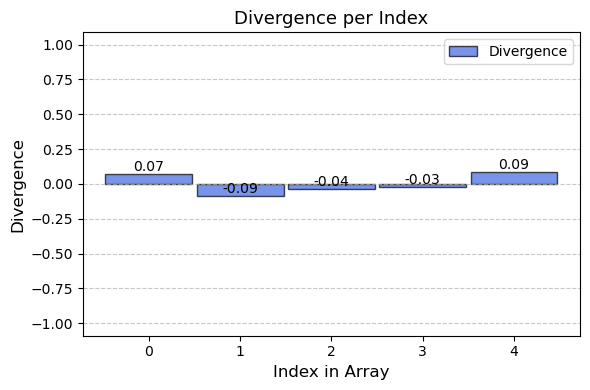

In [9]:
#| label: fig-inspect-ff
#| fig-cap: Concrete predictions and training pairs for the feed-forward model
#| echo: false
df = inspect(model, val_loader, False)
visualize_divergence(df)

Additionally, we will inspect a few samples from the evaluation set, combined with the model output.

In [10]:
#| echo: false
df

,Example Nr.,Type,Values
0,0,input,"0.0850,0.4038,0.4878,0.6103,0.6019"
1,0,prediction,"0.1571,0.3136,0.4480,0.5758,0.6981"
2,0,target,"0.0850,0.4038,0.4878,0.6019,0.6103"
3,5,input,"0.5476,0.8797,0.8482,0.5416,0.5308"
4,5,prediction,"0.2360,0.4701,0.6863,0.8853,1.0755"
5,5,target,"0.5308,0.5416,0.5476,0.8482,0.8797"
6,10,input,"0.9732,0.6948,0.5976,0.8599,0.2902"
7,10,prediction,"0.2506,0.4770,0.7003,0.8977,1.0958"
8,10,target,"0.2902,0.5976,0.6948,0.8599,0.9732"


We can observe that the model seems to make reasonable predictions, but they are imprecise and often include made-up values which are not present in the input-array.

Based on the evaluation, we noticed two further disadvantages of the model architecture in addition to performance:  

- **Fixed input and output size (problem 1):** The model works with a fixed size $s$ for both inputs and outputs. This limits flexibility and makes it difficult to deal with varying data sets.  
- **Simultaneous processing of all inputs (problem 2):** All inputs are used simultaneously to generate all outputs. However, in the case of sorting arrays, the output of a value and the previous values are dependent on each other. This also has the effect that an input value can appear several times in the output of the *FF-network* instead of just once.

These limitations contribute to the suboptimal performance of the model and highlight the need to revise the architecture to improve efficiency and accuracy.

### Seq-to-Seq {#sec-s2s}

To find a solution to these problems, we have defined a Seq-to-Seq model using a recurrent architecture with an LSTM [@hochreiter-1997]. It generates outputs *autoregressive*, meaning that the previous outputs from the model are used to produce the next output. Additionally, this autoregressive nature also allows us to process variable-sized inputs, eliminating both of the problems that the baseline feed-forward architecture in the previous section has.

::: {.callout-tip}
#### Further Reading
- [What is LSTM? Introduction to Long Short-Term Memory - medium](https://medium.com/@rebeen.jaff/what-is-lstm-introduction-to-long-short-term-memory-66bd3855b9ce)
- [What is LSTM – Long Short Term Memory? - geeksforgeeks](https://www.geeksforgeeks.org/deep-learning-introduction-to-long-short-term-memory/)
:::

The Seq-to-Seq architecture, consisting of encoder and decoder, is visualized in @fig-s2s

![Seq-to-Seq architecture](images/s2s.png){#fig-s2s}

Before we can generate outputs,  the model must analyze the entire input. This is why we use an *encoder*, which processes the entire input sequence $x$ and then passes the hidden state $e$ to the decoder as context. The *decoder* receives the context $e$ from the encoder and uses it to generate the output $y$ in an *autoregressive* manner.

Based on this architecture, we now define the model architecture in PyTorch.

In [11]:
class EncoderLstm(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderLstm, self).__init__()

        # LSTM
        self.lstm_cell = nn.LSTMCell(input_size, hidden_size)
        self.hidden_size = hidden_size

    def forward(self, xs, h, c, s):
        hs = []
        for t in range(s):
            xt = xs[:, t, :] # <1>
            h, c = self.lstm_cell(xt, (h, c))
            hs.append(h)

        return torch.stack(hs, dim=1), (h, c)


class DecoderLstm(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(DecoderLstm, self).__init__()

        # Variables
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        # LSTM
        self.lstm_cell = nn.LSTMCell(input_size, hidden_size)

        # Output
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, output_size),
            nn.Sigmoid()  # find out why this helps?
        )

    def forward(self, xs, h, c, s):
        ys = []
        yt = torch.zeros((xs.shape[0], self.output_size))  # SOS

        for t in range(s):
            h, c = self.lstm_cell(yt, (h, c)) #<2>

            yt = self.fc(h) # <3>
            ys.append(yt)

        return torch.stack(ys, dim=1).squeeze(-1)
        

class SeqToSeq(nn.Module):
    def __init__(self, encoder, decoder):
        super(SeqToSeq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, xs):
        xs = xs.unsqueeze(-1)
        b, s = xs.size()[0], xs.size()[1]
        h, c = torch.zeros(b, self.encoder.hidden_size), torch.zeros(b, self.encoder.hidden_size)

        hs, (h, c) = self.encoder(xs, h, c, s)
        return self.decoder(hs, h, c, s) # <4>

1. **Read in data:** First, all input values are read in one after the other (sequentially)
2. **Autoregressive output generation:** The decoder generates it's next hidden state by feeding previous outputs back into the LSTM
3. **LSTM Output Layer:** The LSTM output is projected to a final output $y$ using a linear layer
4. **Initialize Decoder:** The outputs (hidden states) and final hidden state from the encoder are used to initialize the decoder

Afterward, we will use this architecture to train a new model.

In [12]:
#| label: tbl-results-s2s
#| tbl-cap: Training & evaluation metrics for the Seq-to-Seq model
#| echo: false
model = SeqToSeq(
    EncoderLstm(input_size=ITEM_SIZE, hidden_size=HIDDEN_SIZE),
    DecoderLstm(input_size=ITEM_SIZE, hidden_size=HIDDEN_SIZE, output_size=ITEM_SIZE),
)
model, final_loss = train(model, train_loader, use_cross_entropy=False)
accuracy, divergence = evaluate(model, val_loader)
report_s2s = report_training_results("LSTM", accuracy, divergence, None)
report_s2s

,Metric,Value
0,Model,LSTM
1,Embedding Size,None
2,Sequence Length,5
3,Training Epochs,250
4,Accuracy,0.00%
5,Avg. Divergence,0.025922


In [13]:
# echo: false
# inspect(model, val_loader, False)

Looking at the evaluation results, we observe an accuracy score of 0%, indicating that the precision problem of the Feed-Forward network (see @sec-ff) has not yet been resolved. However, the average divergence is improving, suggesting the Seq-to-Seq architecture had a positive effect on the performance.

### Seq-to-Seq with Embeddings {#sec-embedding}

To improve the accuracy of the model, a logical next step would is to improve the input encoding via embeddings, instead of using the values as direct input to the model. Typically, an embedding layer can be implemented by a simple linear layer without bias and without an activation function.


::: {.callout-tip}
#### Further Reading
- [What are Embeddings and how do it work? - medium](https://medium.com/@eugenesh4work/what-are-embeddings-and-how-do-it-work-b35af573b59e)
- [What Is Embedding and What Can You Do with It - towardsdatascience](https://www.geeksforgeeks.org/deep-learning-introduction-to-long-short-term-memory/)
:::

In [14]:
class Embedder(nn.Module):
    def __init__(self, embedding_size):
        super().__init__()
        self.lin = nn.Linear(1, embedding_size, bias=False)

    def forward(self, xs):
        return self.lin(xs)

To use this `Embedder` module in the previously defined `Seq-to-Seq` module, we will integrate it there.

In [15]:
class SeqToSeq(nn.Module):
    def __init__(self, encoder, decoder, embedder=None):
        super(SeqToSeq, self).__init__()
        self.embedder = embedder
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, xs):
        xs = xs.unsqueeze(-1)
        b, s = xs.size()[0], xs.size()[1]
        h, c = torch.zeros(b, self.encoder.hidden_size), torch.zeros(b, self.encoder.hidden_size)

        es = self.embedder(xs) if self.embedder else xs # <1>
        hs, (h, c) = self.encoder(es, h, c, s) # <2>
        return self.decoder(hs, h, c, s)

1. **Embedding generation:** Each of the elements from the input sequence are converted to embeddings
2. **Input to the encoder:** The embeddings are passed to the encoder (instead of the original input sequence)

In [16]:
#| label: tbl-results-embedding
#| tbl-cap: Training & evaluation metrics for the embedding Seq-to-Seq model
#| echo: false
SeqToSeq(
    EncoderLstm(input_size=EMBEDDING_SIZE, hidden_size=HIDDEN_SIZE),
    DecoderLstm(input_size=ITEM_SIZE, hidden_size=HIDDEN_SIZE, output_size=ITEM_SIZE),
    Embedder(embedding_size=EMBEDDING_SIZE)
)
model, final_loss = train(model, train_loader, use_cross_entropy=False)
accuracy, divergence = evaluate(model, val_loader)
report_embedding = report_training_results("LSTM + Embeddings", accuracy, divergence, EMBEDDING_SIZE)
report_embedding

,Metric,Value
0,Model,LSTM + Embeddings
1,Embedding Size,32
2,Sequence Length,5
3,Training Epochs,250
4,Accuracy,0.00%
5,Avg. Divergence,0.015684


By using embeddings, we can observe a continuous decrease in the average divergence.

### Seq-to-Seq with Attention {#sec-attention}

Although the average divergence is improving, it is still not optimal. A common problem of Seq-to-Seq models is, that the hidden state of the encoder-LSTM can become a bottleneck for the entire model [@vinyals-2015A].

This problem can be addressed using an attention-mechanism [@graves-2014], where we not only pass the hidden state $h$ and the cell state $c$ to the decoder, but also include additional information from the original input sequence. This allows the decoder to analyze and weight the input sequences again before making predictions for the outputs.

#### How does the attention mechanism work?

Foremost, we would like to emphasize that there are different types of attentional mechanisms [@graves-2014]. In this article, we will only focus on content based, specifically additive attention. For those interested in exploring other types of attention, additional resources are provided below.

::: {.callout-tip}
##### Further Reading
- [Attention and Self-Attention for NLP - slds-lmu](https://slds-lmu.github.io/seminar_nlp_ss20/attention-and-self-attention-for-nlp.html)
- [Attention in transformers, visually explained | Chapter 6, Deep Learning - 3Blue1Brown](https://www.youtube.com/watch?v=eMlx5fFNoYc)
:::


The following diagram displays how content-based attention is integrated in the encoder-decoder architecture.

![Encoder-decoder architecture with content-based attention](images/content-attention.png){#fig-attention}

To understand what's going on, we will first introduce the basics of content-based attention. Here, we will re-use the following variables from @fig-s2s:

- $d$: decoder hidden state
- $e$: encoder hidden state
- $o$: encoder outputs

Content-based attention as defined by @vinyals-2015B consists of three steps^[We use the same notation as in the paper here, with slight modifications]: First, we calculate a similarity-score $u$ between the encoder outputs $o$ and the decoder hidden states $d$. Each of these scores indicates the relevance of a specific encoder output to the current decoder state.

$$
u_j = v^T \tanh(W_1 o_j + W_2 d)  
$${#eq-u}

In a second step, the softmax-function is applied to the attention-score, resulting in the attentions-weights $a$.

$$a_j = \operatorname{softmax}(u_j)$${#eq-a}

Finally, a context is calculated using the attention-weights $a$ and the encoder outputs $o$.

$$d' = \sum_{j=1}^n a_j o_j$${#eq-c}

By summing these values, we obtain our new hidden state $d'$ for the decoder, which has now been enhanced with additional knowledge about the input sequence.


Going back to @fig-attention, @eq-u is displayed in red, @eq-a in orange and @eq-c in blue. We can see that without attention (grey colors), the decoder would be limited to the information provided in the encoder hidden state $e$. But by using attention, the decoder can include information about the entire input sequence by comparing its own hidden state $d$ to the encoder outputs $o$ at each step while generating outputs. This should mitigate the bottleneck problem discussed in earlier sections (see @sec-s2s).

#### Implementation

We will now proceed by implementing the attention-mechanism in PyTorch.

In [17]:
class AdditiveAttention(nn.Module):
    def __init__(self, key_size, query_size):
        super(AdditiveAttention, self).__init__()
        self.w1 = nn.Linear(key_size, query_size, bias=False)
        self.w2 = nn.Linear(query_size, query_size, bias=False)
        self.v = nn.Linear(query_size, 1, bias=False)
        self.compress = nn.Sequential(
            nn.Linear(query_size * 2, query_size),
            nn.Tanh()
        )

    def forward(self, key, query, create_context, compress_context=False):
        u = self.v(torch.tanh(self.w1(key) + self.w2(query).unsqueeze(1))).squeeze(-1) # <1>
        a = F.softmax(u, dim=1) # <2>
        if create_context:
            r = torch.bmm(a.unsqueeze(1), key).squeeze(1) # <3>
            concat = torch.cat([query, r], dim=1)
            context = self.compress(concat) if compress_context else concat
            return context
        else:
            return a

1. Calculate the similarity-score $u$ (see @eq-u)
2. Calculate the attention-weights $a$ via softmax on $u$ (see @eq-a)
3. "Combine" all the information into a single context, which will be used as the next decoder hidden state $d'$ (see @eq-c)

::: {.callout-note}
Please ignore the `concat` and `compress` steps for now. These are used in the Read-Process-Write architecture introduced in the following sections.
:::

Finally, we will integrate the attention module into the decoder.

In [18]:
class DecoderLstm(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, use_attention):
        super(DecoderLstm, self).__init__()

        # Variables
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        # LSTM
        self.lstm_cell = nn.LSTMCell(input_size, hidden_size)

        # Attention
        self.attention = AdditiveAttention(hidden_size, hidden_size) if use_attention else None # <1>

        # Output
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, output_size),
            nn.Sigmoid()  # find out why this helps?
        )

    def forward(self, xs, h, c, s):
        ys = []
        yt = torch.zeros((xs.shape[0], self.output_size))  # SOS

        for t in range(s):
            h, c = self.lstm_cell(yt, (h, c))

            if self.attention:
                context = self.attention(xs, h, create_context=True, compress_context=True) # <2>
                yt = self.fc(context)
            else:
                yt = self.fc(h)
            ys.append(yt)

        return torch.stack(ys, dim=1).squeeze(-1)

1. Initialize the attention module
2. Apply attention

Using this architecture, we will now train and evaluate an attention-based Seq-to-Seq model on the training data.

In [19]:
#| label: tbl-results-attention
#| tbl-cap: Training & evaluation metrics for the content-attention based Seq-to-Seq model
#| echo: false
model = SeqToSeq(
    EncoderLstm(input_size=EMBEDDING_SIZE, hidden_size=HIDDEN_SIZE),
    DecoderLstm(input_size=ITEM_SIZE, hidden_size=HIDDEN_SIZE, output_size=ITEM_SIZE, use_attention=True),
    Embedder(embedding_size=EMBEDDING_SIZE)
)
model, final_loss = train(model, train_loader, use_cross_entropy=False)
accuracy, divergence = evaluate(model, val_loader)
report_attn = report_training_results("LSTM + Embeddings + Attention", accuracy, divergence, EMBEDDING_SIZE)
report_attn

,Metric,Value
0,Model,LSTM + Embeddings + Attention
1,Embedding Size,32
2,Sequence Length,5
3,Training Epochs,250
4,Accuracy,0.00%
5,Avg. Divergence,0.010806


We can observe that the addition of the attention mechanism significantly reduces the average divergence, which indicates that the bottleneck-problem of the hidden state is being alleviated.

### Seq-to-Seq with Pointers {#sec-pointer}

As previously outlined, the issue of the hidden state bottleneck was addressed through the introduction of attention. Nevertheless, this does not address the issue of precision (see @sec-ff): The problem arises because the network attempts to predict values in the ordered array directly, however because these are `Float32` values, it is highly unlikely that the network will be able to output it in full precision.

To address this issue, we can modify the model to predict indices of the ordered array, instead of values: This means that we will train a model that understands how to rank items without needing to predict exact output values, thereby resolving the precision problem. This idea is known as a pointer network [@vinyals-2015B] and we will implement it in this section.

::: {.callout-tip}
#### Further Reading
- [Pointer networks : What are they? - medium](https://kierszbaumsamuel.medium.com/pointer-networks-what-are-they-c3cb68fae076)
- [The Power of Pointer Networks - hyperscience](https://www.hyperscience.com/blog/the-power-of-pointer-networks/)
:::

Implementing a pointer network is actually a simplified model of the content-based attention Seq-to-Seq model from @sec-attention. The diagram below displays the Seq-to-Seq architecture using a pointer network as a decoder.

![ Encoder-decoder architecture with a pointer net](images/ptr-attention.png){#fig-ptr}

The pointer network is essentially content-based attention, but without calculating a context (@eq-c) and instead using the attention-weights (see @eq-a) as outputs. These attention-weights are a distribution over the input-vocabulary and can therefore serve as "pointers" to the input vocabulary. To use this distribution as a hidden-state for subsequent steps, we simply do a matrix multiplication with this distribution to convert it into a scalar-value.

In [20]:
class DecoderPointerLstm(nn.Module):
    def __init__(self, hidden_size, use_attention):
        super(DecoderPointerLstm, self).__init__()

        # LSTM
        self.lstm_cell = nn.LSTMCell(hidden_size, hidden_size)

        # Attention
        self.attention = AdditiveAttention(hidden_size, hidden_size) if use_attention else None
        self.hidden_size = hidden_size

    def forward(self, xs, h, c, s):
        ys = []
        yt = torch.zeros((xs.shape[0], self.hidden_size))  # SOS

        for t in range(s):
            h, c = self.lstm_cell(yt, (h, c))

            # now returns a softmax distribution
            p = self.attention(xs, h, create_context=False) # <1>
            ys.append(p)

            # compile next input
            # this could also be just the pointer distribution, but would restrict
            # the model to a specific sequence length (not generalizable) so we compile
            # a new state from it
            yt = torch.bmm(p.unsqueeze(1), xs).squeeze(1) # <2>

        return torch.stack(ys, dim=1)

1. **No Context Vector Creation:** Directly return the attention-weights which serve as pointers to the input-vocabulary
2. **Compress softmax distribution:** Calculate a scalar value to serve as the next hidden state for the decoder

Using this new architecture, we will train and evaluate a pointer-net based Seq-to-Seq model.

In [21]:
#| label: tbl-results-ptr
#| tbl-cap: Training & evaluation metrics for the pointer Seq-to-Seq model
#| echo: false
model = SeqToSeq(
    EncoderLstm(input_size=EMBEDDING_SIZE, hidden_size=HIDDEN_SIZE),
    DecoderPointerLstm(hidden_size=HIDDEN_SIZE, use_attention=True),
    Embedder(embedding_size=EMBEDDING_SIZE)
)
model, final_loss = train(model, train_loader, use_cross_entropy=True)
accuracy, divergence = evaluate(model, val_loader)
report_ptr = report_training_results("LSTM + Embeddings + Attention + Pointer", accuracy, divergence, EMBEDDING_SIZE)
report_ptr

,Metric,Value
0,Model,LSTM + Embeddings + Attention + Pointer
1,Embedding Size,32
2,Sequence Length,5
3,Training Epochs,250
4,Accuracy,93.05%
5,Avg. Divergence,0.00228


The results improve significantly with the addition of the pointer mechanism: Not only is the accuracy metric working, indicating that we have solved the precision problem, but also the average divergence is decreasing as a side effect of the model predicting more precise values.

Comparing the model output with the target values directly (see @tbl-inspect-ptr), it is difficult to find wrong outputs due to the high accuracy. However, we can observe that when the model makes a mistake, the resulting value is still guaranteed to be present in the input array, due to the pointer mechanism.

In [23]:
#| label: tbl-inspect-ptr
#| tbl-cap: Concrete predictions and training pairs for the pointer Seq-to-Seq model
#| echo: false
df = inspect(model, val_loader, True)
df

,Example Nr.,Type,Values
0,0,input,"0.0850,0.4038,0.4878,0.6103,0.6019"
1,0,prediction,"0.0850,0.4038,0.4878,0.6019,0.6103"
2,0,target,"0.0850,0.4038,0.4878,0.6019,0.6103"
3,5,input,"0.5476,0.8797,0.8482,0.5416,0.5308"
4,5,prediction,"0.5416,0.5476,0.5476,0.8482,0.8797"
5,5,target,"0.5308,0.5416,0.5476,0.8482,0.8797"
6,10,input,"0.9732,0.6948,0.5976,0.8599,0.2902"
7,10,prediction,"0.2902,0.5976,0.6948,0.8599,0.9732"
8,10,target,"0.2902,0.5976,0.6948,0.8599,0.9732"


### Read-Process-Write Architecture {#sec-rpw}

The Seq-to-Seq architecture combined with a pointer network already achieves good results. However, there is an important observation to be made: The Seq-to-Seq architecture is reading the inputs sequentially and generating outputs sequentially (see @fig-s2s). As a result, the order in which the input array is presented has an effect on the performance of the model because it changes the encoding. This property can be advantageous when dealing with sequential data, but not for Set2Set. Sets, by definition lack order and thus every set should be encoded identically (see @vinyals-2015A). 

Read-Process-Write Architecture, introduced by @vinyals-2015A addresses this problem by using an *order invariant encoding* via content-based attention in the encoder and a *glimpse* mechanism in the decoder for *order invariant decoding*.

Compared to the previous sections, we will now continue with the notation from @vinyals-2015A with slight modifications so that the reader can easily compare our implementation to the paper.

- $m$: Memory vector (previously embeddings)
- $q$: Hidden state of the LSTM (previously $h$)
- $q^*$: Concatenation of the hidden State of the LSTM + attention readout: $[q, r]$

@fig-rpw displays the Read-Process-Write architecture, excluding the glimpse mechanism, which will be described in a following section.

![Read-Process-Write architecture (simplified without glimpse-mechanism)](images/rpw.png){#fig-rpw .ligthbox}

Although this diagram is more verbose than @fig-s2s, in essence the Read-Process-Write architecture can be understood as an Encoder-Decoder model with embeddings. In fact, in our implementation, we use the same embedder introduced in @sec-embedding for this model. The encoder is called the *Process* block and the main difference to the Seq-toSeq encoder from @fig-s2s is, that it can "see" the input sequence $m$ only via an attention mechanism, instead of as input into the LSTM, resulting in an *order invariant encoding*. As a side effect, we can now also specify how many process steps we want to take, potentially even more than the sequence length $s$ of the input array ^[In our implementation we're using 5 processing steps, but these can be adjusted as seen fit].

In [24]:
class ProcessEncoderLstm(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(ProcessEncoderLstm, self).__init__()

        # LSTM
        self.lstm_cell = nn.LSTMCell(hidden_size * 2, hidden_size)

        # Attention
        self.attention = AdditiveAttention(key_size=input_size, query_size=hidden_size)

    def forward(self, ms, q_star, h, c, process_steps):
        for t in range(process_steps): # <1>
            q, c = self.lstm_cell(q_star, (h, c)) # <2>

            q_star = self.attention(ms, q, create_context=True) # <3>

        return q_star

1. **Independent lengths:** The encoding is not dependent on the length of the input sequence anymore. This gives more flexibility and the potential to define the number of processing steps manually.
2. **Input Modification:** Instead of feeding the inputs $m$ sequentially into the encoder LSTM, we're using $q^*$ as the input
3. **$q^*$ generation**: Concatenation of the previous hidden state $q$ and the attention readout from comparing the memory vector $m$ with $q$

As shown in @fig-rpw, $q^*$ from the *Process* block is used to initialize the *Write* block. The *Write* block is mostly identical to the decoder pointer-network introduced in @sec-pointer, with the addition of a glimpse-mechanism, which was also introduced by @vinyals-2015A. Glimpse is another content-based attention module which is calculated from $q^*$ and the memory vector $m$. The glimpse-value $g$ is then passed as input $x$ and $q^*$  as the hidden state $h$ to the LSTM. Although the authors only briefly describe the design-decision behind this mechanism, it increases the performance of the model significantly. While the decoder in the Seq-to-Seq architecture was able to rely on its previous outputs as inputs $x$ for the following steps, in a non-sequential setting as in Set-to-Set, this is not the case, and the glimpse value $g$ serves as a non-sequential replacement for it.

In [25]:
class WriteDecoderPointerLstm(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(WriteDecoderPointerLstm, self).__init__()

        # LSTM
        self.lstm_cell = nn.LSTMCell(input_size, hidden_size)
        self.input_size = input_size

        # Attention
        self.attention = AdditiveAttention(key_size=input_size, query_size=hidden_size)
        self.hidden_size = hidden_size

        # Glimpse
        self.glimpse = AdditiveAttention(key_size=input_size, query_size=input_size) # <1>
        self.glimpse_projection = nn.Linear(hidden_size, input_size) # <2>

    def forward(self, m, h, c, s):
        ys = []

        for t in range(s):
            # glimpse
            # h = q_star (from process-block)
            g = self.glimpse(m, self.glimpse_projection(h), create_context=True, compress_context=True) # <3>

            h, c = self.lstm_cell(g, (h, c))

            # returns softmax
            y = self.attention(m, h, create_context=False)
            ys.append(y)

        return torch.stack(ys, dim=1)

1. **Initialize glimpse:** Glimpse is just another attention module
2. **Initialize a projection layer:** This makes the shapes of the hidden state $q^*$ and memory vector $m$ compatible
3. **Apply glimpse:** Before generating a new hidden state, calculate the glimpse value $g$ to use as the input $x$ for the LSTM

To combine the *Read*, *Process* and *Write* modules into a single model, we will introduce the `RPW` class using pytorch.

In [26]:
class ProcessBlock(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.module = ProcessEncoderLstm(input_size=input_size, hidden_size=hidden_size)
        self.hidden_size = hidden_size

    def forward(self, ms, s):
        bs = ms.size(0)
        q_star = torch.zeros(bs, self.hidden_size * 2)
        h = torch.zeros(bs, self.hidden_size)
        c = torch.zeros(bs, self.hidden_size)

        return self.module(ms, q_star, h, c, s)


class WriteBlock(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.module = WriteDecoderPointerLstm(input_size=input_size, hidden_size=hidden_size * 2)

    def forward(self, m, q_star):
        bs, s = m.size(0), m.size(1)
        c = torch.zeros(bs, self.module.hidden_size)

        return self.module(m, q_star, c, s)


class RPW(nn.Module):
    def __init__(self, embedding_size, hidden_size, process_steps):
        super().__init__()
        self.read = Embedder(embedding_size=embedding_size)
        self.process = ProcessBlock(input_size=embedding_size, hidden_size=hidden_size)
        self.write = WriteBlock(input_size=embedding_size, hidden_size=hidden_size)
        self.process_steps = process_steps

    def forward(self, xs):
        xs = xs.unsqueeze(-1)
        m = self.read(xs)
        q_star = self.process(m, self.process_steps) # <1>
        pointers = self.write(m, q_star) # <2>

        return pointers

1. Generates a hidden state $q^*$ which is used to initialize to *Write* module. This encoding is order invariant.
2. Generates the pointer distribution using the newly added glimpse mechanism

Finally, we will train and evaluate a new model with this architecture.

In [27]:
#| label: tbl-results-rpw
#| tbl-cap: Training & evaluation metrics for the Read-Process-Write architecture
#| echo: false
model = RPW(EMBEDDING_SIZE, HIDDEN_SIZE, PROCESS_STEPS)
model, final_loss = train(model, train_loader, use_cross_entropy=True)
accuracy, divergence = evaluate(model, val_loader)
report_rpw = report_training_results("Read-Process-Write (Pointer)", accuracy, divergence, EMBEDDING_SIZE)
report_rpw

,Metric,Value
0,Model,Read-Process-Write (Pointer)
1,Embedding Size,32
2,Sequence Length,5
3,Training Epochs,250
4,Accuracy,98.70%
5,Avg. Divergence,0.00036


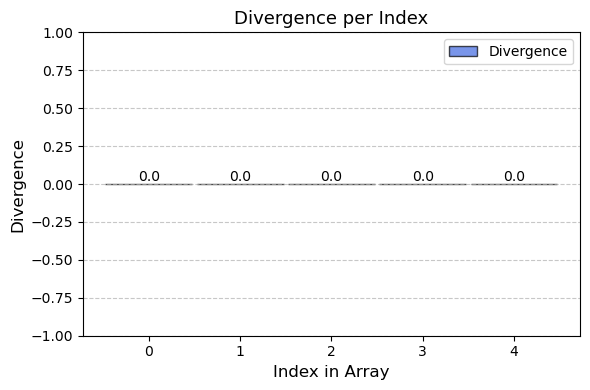

In [29]:
#| label: fig-inspect-rpw
#| fig-cap: Concrete predictions and training pairs for the Read-Process-Write model
#| echo: false
df = inspect(model, val_loader, True)
visualize_divergence(df)

The results show almost perfect accuracy values and a very low divergence. This indicates that the order invariant encoding / decoding, which is implemented via content-based attention, improves the performance. With more processing steps and longer training time, this performance can be improved even further.

## Summary

The Seq-to-Seq architecture is useful for processing sequential data of varying lengths, but faces challenges when dealing with unordered inputs or outputs. In this article, we highlight the strengths of the Read-Process-Write architecture, which is an extension of the classical Seq-to-Seq paradigm to a Set-to-Set paradigm, by building the final model from the ground up and comparing the performance improvements at each step. LSTMs are better at handling variable-length sequences than a baseline feed-forward networks (see @sec-ff), and can be combined into a Seq-to-Seq model with an encoder and decoder (see @sec-s2s), potentially also using embeddings for improved performance (see @sec-embedding). Incorporating an attention-mechanism can help to overcome the hidden-state bottleneck, significantly improving performance (see @sec-attention). The introduction of pointer networks, on the other hand, allows the model to be more accurate in its output, by predicting indices from the input vocabulary rather than the values directly (see @sec-pointer). Finally, by processing the inputs for the encoder and decoder LSTM in a non-sequential manner via attention, the Read-Process-Write architecture (see @sec-rpw) eliminates the sequential limitation of Seq-to-Seq models and results in a Set-to-Set architecture, which may be used to solve the problem of sorting numbers introduced in this article.